1. Momentum and Contrarian are very popular strategies
2. Using these strategies on a standalone basis is almost guaranteed to lose money, because they lead to excessive trading and changing of positions. It becomes impossible then to recover trading costs with these strategies
3. Momentum strategy is direct opposite to contrarian strategy, but the rationale behind both is the same
4. Momentum - 
    * If the most recent period's candle is up/down, take long/short position. 
    * The assumption is that the trend will persist 
    * Some variations could be introduced such as, instead of taking only one period in account, mean return of previous three or five periods can be considered. If return is positive, go long and vice-versa
6. Contrarian - 
    * The assumption is that the most recent trend will not persist and the market would go in opposite direction.
    * If the most recent period's candle is up/down, take short/long position.

# Getting the Data

In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# importing data from intraday.csv using read_csv() method in pandas
data = pd.read_csv('intraday.csv', parse_dates = ['time'], index_col = 'time')
data.head()

,price
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690


1. Here we have a granularity of 6 hours. 
2. The time on left is the starting time (left bound)
3. The price 1.201205 is the close price for period starting at 22:00 and ending at 04:00

In [3]:
# checking information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2070 entries, 2018-01-01 22:00:00+00:00 to 2019-12-30 22:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2070 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


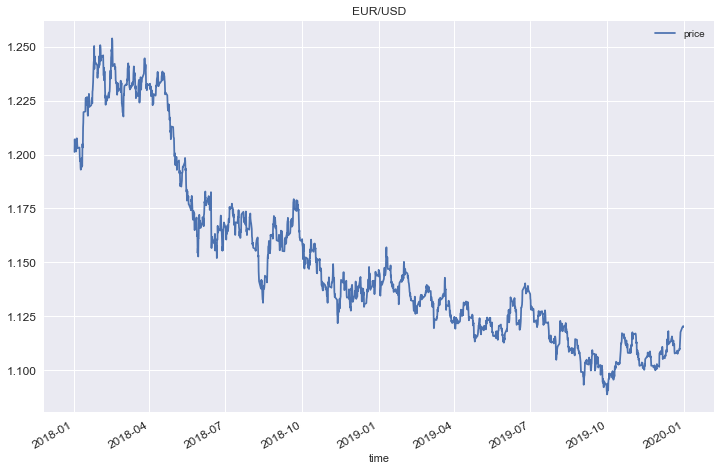

In [4]:
# Creating a price chart for visualisation purpose
data.plot(figsize = (12,8), title = 'EUR/USD', fontsize = 12)
plt.show()

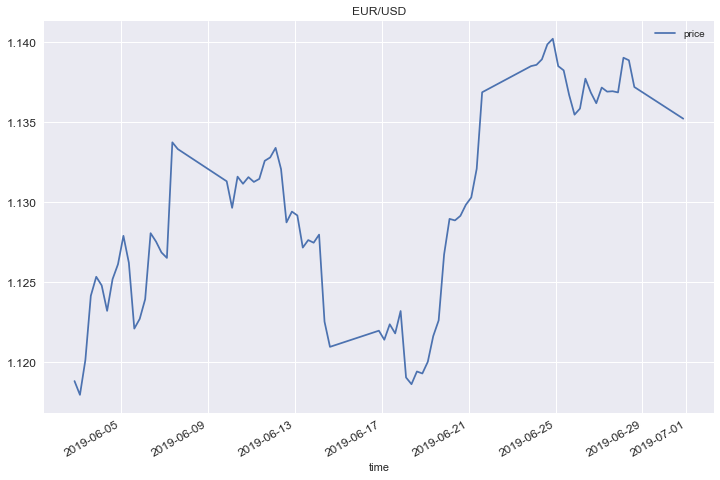

In [5]:
# plotting for a particular month e.g. June 2019
data.loc['2019-06'].plot(figsize = (12,8), title = 'EUR/USD', fontsize = 12)
plt.show()

In [6]:
# Calculating log returns and adding a column to our data
data['returns'] = np.log(data.div(data.shift(1)))

In [7]:
# dropping the na values and observing
data.dropna(inplace = True)
data.head()

,price,returns
time,,
2018-01-02 04:00:00+00:00,1.207055,0.004858
2018-01-02 10:00:00+00:00,1.204440,-0.002169
2018-01-02 16:00:00+00:00,1.205800,0.001129
2018-01-02 22:00:00+00:00,1.204690,-0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718


In [8]:
# We can resample the data in 12 hour periods instead of 6 hour using data.price.resample('12h').last()

# Defining a simple Contrarian strategy (window = 3)
1. We consider the 3 most recent closing prices to decide whether we go long or short
2. The intuition behind a contrarian strategy is:
    * If the mean return of the most recent 3 closing prices is POSITIVE, take SHORT position
    * If the mean return of the most recent 3 closing prices is NEGATIVE, take LONG position

In [9]:
# Specifying window as 3
window = 3

In [10]:
# creating a rolling window for returns. Taking mean of most recent 3 returns
data['returns'].rolling(window).mean()

time
2018-01-02 04:00:00+00:00             NaN
2018-01-02 10:00:00+00:00             NaN
2018-01-02 16:00:00+00:00    1.272676e-03
2018-01-02 22:00:00+00:00   -6.537454e-04
2018-01-03 04:00:00+00:00   -1.702470e-04
                                 ...     
2019-12-29 22:00:00+00:00    1.808598e-03
2019-12-30 04:00:00+00:00    1.085156e-03
2019-12-30 10:00:00+00:00    7.492899e-04
2019-12-30 16:00:00+00:00   -1.484453e-17
2019-12-30 22:00:00+00:00    1.234956e-04
Name: returns, Length: 2069, dtype: float64

In [11]:
# Creating a column for positions taken in our dataframe. The minus sign signals that it is a contrarian strategy
# This negative sign is the only difference between a simple momentum and a simple contrarian strategy
data['position'] = -np.sign(data['returns'].rolling(window).mean())

In [12]:
data.head()

,price,returns,position
time,,,
2018-01-02 04:00:00+00:00,1.207055,0.004858,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0


# Vectorized Strategy Backtesting
1. We use vectorized pandas code to compare our strategy with 'buy and hold' strategy.
2. Vectorized because our positions are +1 and -1
3. # We need to shift the position column down by one timeframe because the mean of most recent 3 closing prices, would determine the strategy for next period

In [13]:
# adding a strategy column which shows shifted position by one timestamp, multiplied by returns
data['strategy'] = data.position.shift(1) * data['returns']
data.dropna(inplace = True) # dropping the na values from dataframe
data.head()

,price,returns,position,strategy
time,,,,
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718
2018-01-03 10:00:00+00:00,1.202355,-0.001222,1.0,-0.001222
2018-01-03 16:00:00+00:00,1.201445,-0.000757,1.0,-0.000757
2018-01-03 22:00:00+00:00,1.201450,0.000004,1.0,0.000004


In [14]:
# Calculating absolute performance of our strategy and of buy and hold
data[['returns', 'strategy']].sum()

returns    -0.073498
strategy    0.096236
dtype: float64

Over two years, buy and hold returns -7.3% and our strategy returns +9.6%

In [15]:
# Another way to calculate performance is to calculate the value of $1 invested over time in strategy
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.929138
strategy    1.101019
dtype: float64

In [16]:
# Adding columns for cumulative returns of 'buy and hold' and our strategy
data['creturns'] = data['returns'].cumsum().apply(np.exp)
data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
data.tail()

,price,returns,position,strategy,creturns,cstrategy
time,,,,,,
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420
2019-12-30 16:00:00+00:00,1.119920,-0.000156,1.0,0.000156,0.928778,1.100591
2019-12-30 22:00:00+00:00,1.120355,0.000388,-1.0,0.000388,0.929138,1.101019


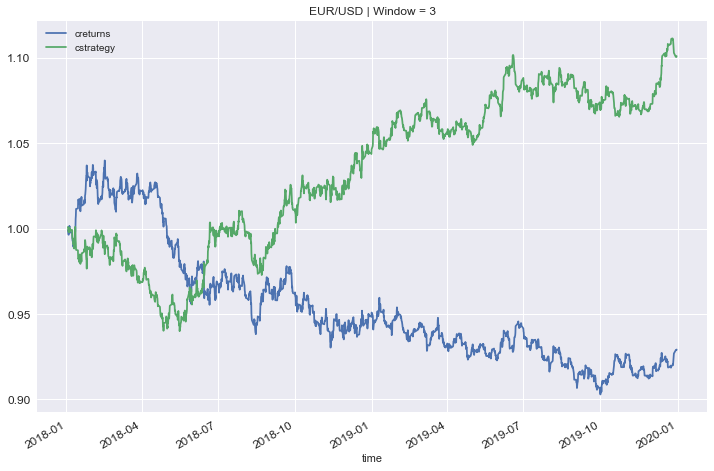

In [17]:
# Plotting cumulative returns to compare performance of our strategy with buy and hold
data[['creturns','cstrategy']].plot(figsize = (12,8), title = 'EUR/USD | Window = {}'.format(window), fontsize = 12)
plt.show()

# Changing the window parameter
1. The aim to change window parameter from 3 to 1,2,5 or 10 and then compare performance side by side
2. for loop would be utilised to achieve this efficiently

In [18]:
# Importing the dataset from a csv file
data = pd.read_csv('intraday.csv', parse_dates = ['time'], index_col = 'time')
data.head()

,price
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690


In [19]:
# Adding a column for returns to dataframe
data['returns'] = np.log(data.div(data.shift(1)))
data.dropna(inplace = True)
data.head()

,price,returns
time,,
2018-01-02 04:00:00+00:00,1.207055,0.004858
2018-01-02 10:00:00+00:00,1.204440,-0.002169
2018-01-02 16:00:00+00:00,1.205800,0.001129
2018-01-02 22:00:00+00:00,1.204690,-0.000921
2018-01-03 04:00:00+00:00,1.203825,-0.000718


In [20]:
# Initialising a list to_plot with column labels we want to plot
to_plot = ['returns']

Creating a for loop to compare Contrarian strategy returns for different window size
1. There are two columns for each contrarian strategy
2. We iterate over a list which has our desired window sizes 1,2,3,5,10

In [21]:
for w in [1,2,3,5,10]:
    data['position {}'.format(w)] = -np.sign(data['returns'].rolling(w).mean())
    data['strategy {}'.format(w)] = data['position {}'.format(w)].shift(1) * data['returns']
    to_plot.append('strategy {}'.format(w))

In [22]:
# Inspecting the dataframe
data.head()

,price,returns,position 1,strategy 1,position 2,strategy 2,position 3,strategy 3,position 5,strategy 5,position 10,strategy 10
time,,,,,,,,,,,,
2018-01-02 04:00:00+00:00,1.207055,0.004858,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:00:00+00:00,1.204440,-0.002169,1.0,0.002169,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 16:00:00+00:00,1.205800,0.001129,-1.0,0.001129,1.0,-0.001129,-1.0,NaN,NaN,NaN,NaN,NaN
2018-01-02 22:00:00+00:00,1.204690,-0.000921,1.0,0.000921,-1.0,-0.000921,1.0,0.000921,NaN,NaN,NaN,NaN
2018-01-03 04:00:00+00:00,1.203825,-0.000718,1.0,-0.000718,1.0,0.000718,1.0,-0.000718,-1.0,NaN,NaN,NaN


In [23]:
# our plotting list columns
to_plot

['returns',
 'strategy 1',
 'strategy 2',
 'strategy 3',
 'strategy 5',
 'strategy 10']

* Plotting our list columns:
    1. Selecting the list columns
    2. dropping missing values
    3. Taking cumulative sum of strategy returns and applying exponent to calculate value of $1 invested over time

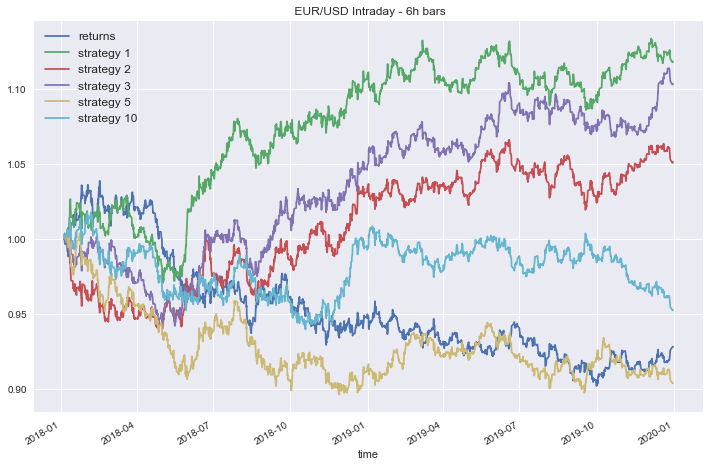

In [24]:
# PLotting to compare our strategy returns with buy and hold returns
data[to_plot].dropna().cumsum().apply(np.exp).plot(figsize = (12,8))
plt.title(' EUR/USD Intraday - 6h bars', fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

1. It can be observed from the plot above that our contrarian strategy is very sensitive to the window parameter.
2. Strategy with window = 5 infact did worse than buy and hold strategy

# Trades and Trading Costs
1. Since momentum/contrarian strategies involve taking a large number of trades, we must take into account trading costs as well
2. It is imperative to take trading costs into account when backtesting
3. Even if a strategy is profitable before costs, it might lead to losses when trading costs are considered

In [32]:
# starting from scratch and redoing everything for practice. If in doubt, check comments in above sections
data = pd.read_csv('intraday.csv', parse_dates = ['time'], index_col = 'time')
window = 3
data['returns'] = np.log(data.div(data.shift(1)))
data['position'] = -np.sign(data['returns'].rolling(window).mean())
data['strategy'] = data.position.shift(1) * data['returns']
data.dropna(inplace = True)
data['creturns'] = data['returns'].cumsum().apply(np.exp)
data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
data.tail()

,price,returns,position,strategy,creturns,cstrategy
time,,,,,,
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420
2019-12-30 16:00:00+00:00,1.119920,-0.000156,1.0,0.000156,0.928778,1.100591
2019-12-30 22:00:00+00:00,1.120355,0.000388,-1.0,0.000388,0.929138,1.101019


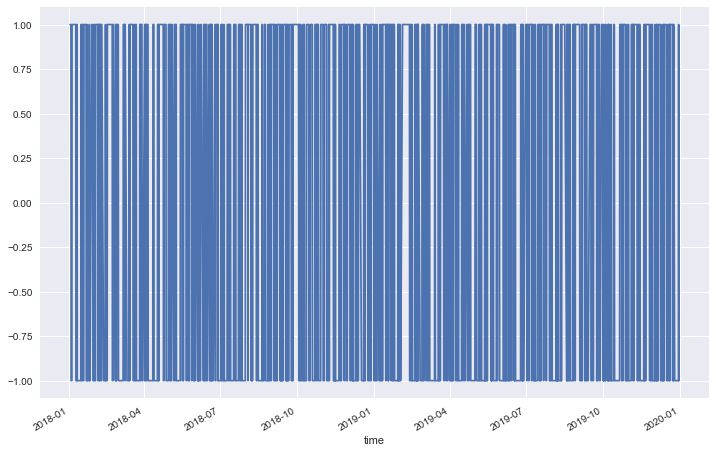

In [33]:
# Plotting the change of positions over time
data.loc[:, 'position'].plot(figsize = (12,8))
plt.show()

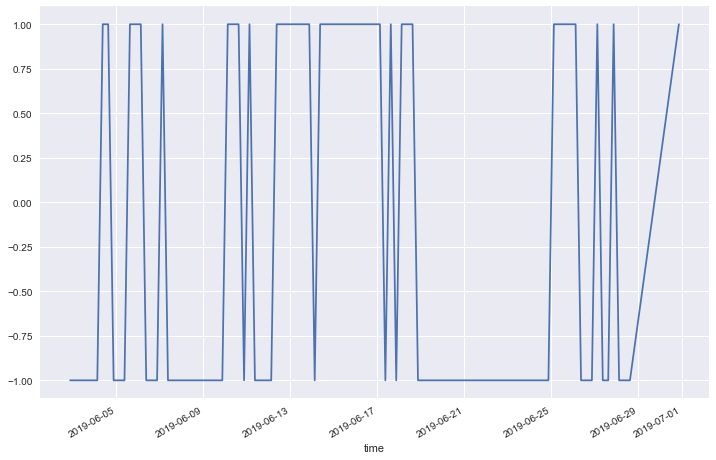

In [34]:
# Increasing the granularity of the plot. Checking only july 2019
data.loc['2019-06', 'position'].plot(figsize = (12,8))
plt.show()

1. Trading/Transaction costs (simplified)
    * Brokers like OANDA and FXCM charge bid-ask spread on every transaction/trade
    * Vectorised backtesting is limited when adding/simulating for trading costs
    * With event-based backtesting we can incorporate transaction costs in a more detailed manner

In [35]:
# Typical bid-ask spread for EUR/USD is 1.5 pips. Pip == fourth place decimal
spread = 1.5 * 0.0001
spread

0.00015000000000000001

If we buy/sell 1 euro, we have to pay this spread as transaction cost to open and close the trade

In [36]:
# In one trade we pay half spread, the other half is paid when we close the trade (position change +-1)
half_spread = spread / 2
half_spread

7.500000000000001e-05

In [38]:
# Calculating proportional transaction cost per trade for change of position from +-1. 
# We need to divide half spread by mean price
ptc = half_spread / data.price.mean()
ptc

6.520065892008915e-05

In [40]:
# Rouding up ptc to 0.00007. This is our assumed proportionate cost
pct = 0.00007

In reality we need to consider prevailing bid-ask spread and trade price everytime we calculate trading cost, but here we are taking average of both for simplicity

In [42]:
data.tail()

,price,returns,position,strategy,creturns,cstrategy
time,,,,,,
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420
2019-12-30 16:00:00+00:00,1.119920,-0.000156,1.0,0.000156,0.928778,1.100591
2019-12-30 22:00:00+00:00,1.120355,0.000388,-1.0,0.000388,0.929138,1.101019


In [43]:
# defining and calculating number of trades for each period
# selecting position column and calculating difference in position from last period to current period
# Changing position from -1 to 1 means 2 trades
# Filling missing values with 0
# Calculating absolute value so that it is independent of sign
data['trades'] = data.position.diff().fillna(0).abs()

In [44]:
data.tail()

,price,returns,position,strategy,creturns,cstrategy,trades
time,,,,,,,
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591,0.0
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572,0.0
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420,0.0
2019-12-30 16:00:00+00:00,1.119920,-0.000156,1.0,0.000156,0.928778,1.100591,2.0
2019-12-30 22:00:00+00:00,1.120355,0.000388,-1.0,0.000388,0.929138,1.101019,2.0


In [45]:
# Counting total trades
data.trades.value_counts()

0.0    1513
2.0     553
Name: trades, dtype: int64

1. 553 trades is massive. So we see that our contrarian strategy leads to excessive trading
2. Each trade reduces our profit by proportional transaction costs
3. Calculate net strategy returns per period by multiplying number of trades with pct and subtracting with strategy return per period

In [46]:
# Calculating net strategy returns and adding column to dataframe
data['strategy_net'] = data.strategy - data.trades * pct

In [47]:
# Adding a column for net cumulative strategy returns as well
data['cstrategy_net'] = data.strategy_net.cumsum().apply(np.exp)

In [48]:
data.tail()

,price,returns,position,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
time,,,,,,,,,
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.928778,1.100591,0.0,-0.002092,1.018884
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.928794,1.100572,0.0,-0.000018,1.018866
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.928923,1.100420,0.0,-0.000138,1.018725
2019-12-30 16:00:00+00:00,1.119920,-0.000156,1.0,0.000156,0.928778,1.100591,2.0,0.000016,1.018741
2019-12-30 22:00:00+00:00,1.120355,0.000388,-1.0,0.000388,0.929138,1.101019,2.0,0.000248,1.018994


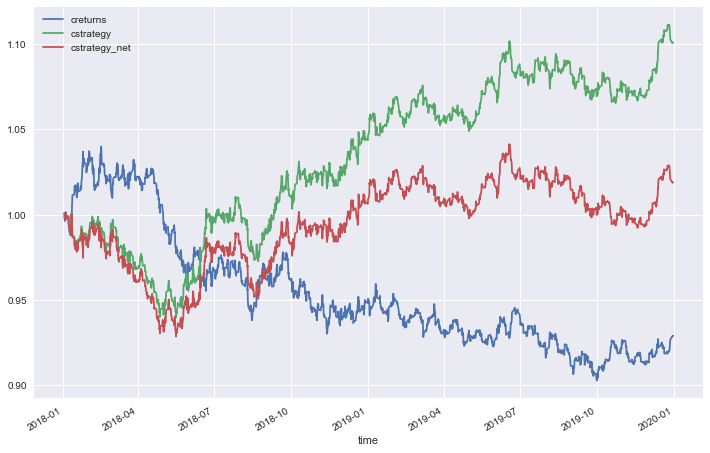

In [49]:
# Plotting net strategy returns, strategy returns and buy and hold returns for comparison
data[['creturns', 'cstrategy', 'cstrategy_net']].plot(figsize = (12,8))
plt.show()

1. Trading costs eat up approximately 50% of the outperformance here
2. Heavy day trading with simple contrarian or momentum strategy is a waste of money, it turns out